In [41]:
# import keras dependencies 
from keras.models import Model
from keras.applications import MobileNet as CNN
from keras.applications.mobilenet import preprocess_input
from keras.layers import Flatten
from keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
from IPython.display import Image 
from PIL import Image
import matplotlib.pyplot as plt
import time
import pickle
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
import pandas as pd

from collections import defaultdict

warnings.filterwarnings("ignore")
%matplotlib inline

#### Load existing model artifacts

In [2]:
def pickle_loader(path):
    with open(path, 'rb') as rb:
        temp = pickle.load(rb)
    return temp

def get_matches_above_threshold(row, thresh):
    valid_inds = np.where(row >= thresh)[0]
    valid_vals = row[valid_inds]
    return valid_inds, valid_vals

feat_vecs_ret_l3 = pickle_loader('var_1r.pkl')
feat_vecs_query_l3 = pickle_loader('var_1q.pkl')
file_mapping_ret_l3 = pickle_loader('docs_1r.pkl')
file_mapping_query_l3 = pickle_loader('docs_1q.pkl')

# feat_vecs_ret_l9 = pickle_loader('var_2r.pkl')
# feat_vecs_query_l9 = pickle_loader('var_2q.pkl')
# file_mapping_ret_l9 = pickle_loader('docs_2r.pkl')
# file_mapping_query_l9 = pickle_loader('docs_2q.pkl')

### Cosine Evaluation Analysis
#### New `CosEval` Class

In [3]:
class CosEval:
    def __init__(self, query_vector, ret_vector):
        self.query_vector = query_vector
        self.ret_vector = ret_vector
        self.normalize_vector_matrices()


    def normalize_vector_matrices(self):
        self.normed_query_vector = self.get_normalized_matrix(self.query_vector)
        self.normed_ret_vector = self.get_normalized_matrix(self.ret_vector)

        
    @staticmethod    
    def get_normalized_matrix(x):
        x_norm_per_row = norm(x, axis=1)
        x_norm_per_row = x_norm_per_row[:, np.newaxis] # adding another axis
        x_norm_per_row_tiled = np.tile(x_norm_per_row, (1, x.shape[1]))
        x_normalized = x/x_norm_per_row_tiled 
        return x_normalized 

In [4]:
l3 = CosEval(feat_vecs_query_l3, feat_vecs_ret_l3)
feat_vecs_query_norm = l3.normed_query_vector
feat_vecs_ret_norm = l3.normed_ret_vector

In [5]:
%time sim_vec = np.dot(feat_vecs_query_norm, feat_vecs_ret_norm.T)

CPU times: user 1.04 s, sys: 47 ms, total: 1.08 s
Wall time: 326 ms


## List of potential experiments
+ Histogram over similarity scores
+ Histogram of number of retrievals (at thresh = T)
+ Histogram of most frequently returned transformation(at threshold = T)
+ Average similarity score for correct retrievals (at threshold = T)
+ Average similarity score for incorrect retrievals (at threshold = T)
+ Average similarity score for each type of transformation (at threshold = T)

##### In Progress
+ Average overall retrieval position for correct & incorrect retrievals (at threshold = T)
+ Average retrieval position for each type of transformation (at threshold = T)

### 1.Histogram over similarity scores

In [6]:
def hist_plot(arr, title):
    fig, axes = plt.subplots(1, 1, figsize=(16,6))
    sns.distplot(arr, kde=False)
    plt.title(title)
    plt.show()

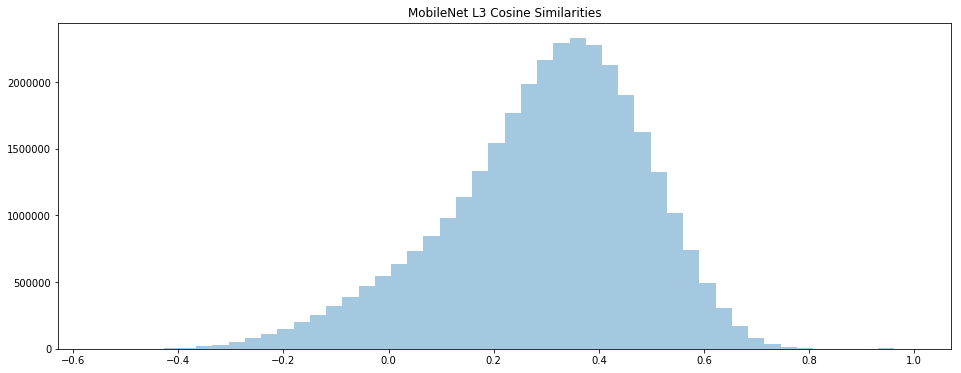

In [7]:
all_sims = list(np.ndarray.flatten(sim_vec))
hist_plot(all_sims, 'MobileNet L3 Cosine Similarities')

### 2. Histogram of number of retrievals (at thresh = T)

In [8]:
def get_retrievals_at_thresh(vec, file_mapping_query, file_mapping_ret, thresh=0.8):
    dict_ret = {}
    for i in range(vec.shape[0]):
        valid_inds, valid_vals = get_matches_above_threshold(vec[i, :], thresh)
        retrieved_files = [file_mapping_ret[j] for j in valid_inds]
        query_name = file_mapping_query[i]
        dict_ret[query_name] = dict(zip(retrieved_files, valid_vals))
    return dict_ret

In [9]:
dict_l3_t1 = get_retrievals_at_thresh(sim_vec, file_mapping_query_l3, file_mapping_ret_l3, 0.4)
dict_l3_t2 = get_retrievals_at_thresh(sim_vec, file_mapping_query_l3, file_mapping_ret_l3, 0.6)
dict_l3_t3 = get_retrievals_at_thresh(sim_vec, file_mapping_query_l3, file_mapping_ret_l3, 0.8)
dict_l3_t4 = get_retrievals_at_thresh(sim_vec, file_mapping_query_l3, file_mapping_ret_l3, 0.9)

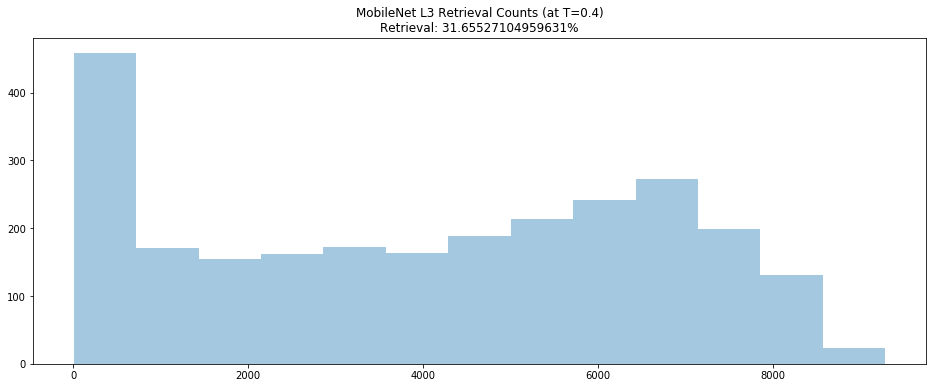

In [10]:
all_ret_counts_t1 = [len(dict_l3_t1[query])for query in dict_l3_t1]
hist_plot(all_ret_counts_t1, f'MobileNet L3 Retrieval Counts (at T=0.4)\nRetrieval: {np.sum(all_ret_counts_t1)*100/len(all_sims)}%')

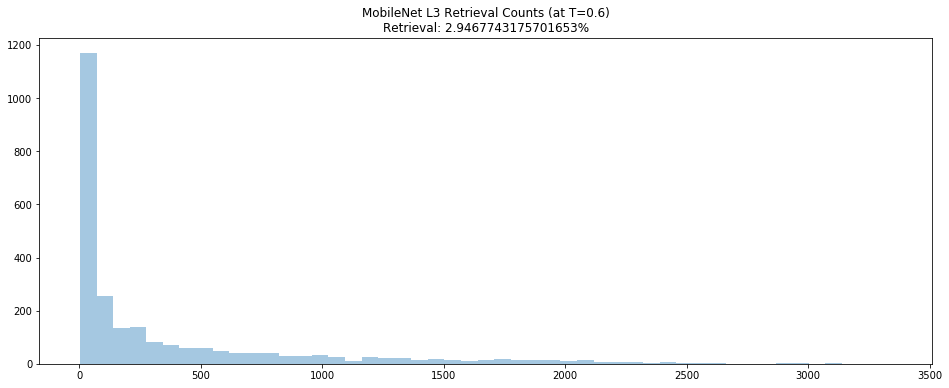

In [11]:
all_ret_counts_t2 = [len(dict_l3_t2[query])for query in dict_l3_t2]
hist_plot(all_ret_counts_t2, f'MobileNet L3 Retrieval Counts (at T=0.6)\nRetrieval: {np.sum(all_ret_counts_t2)*100/len(all_sims)}%')

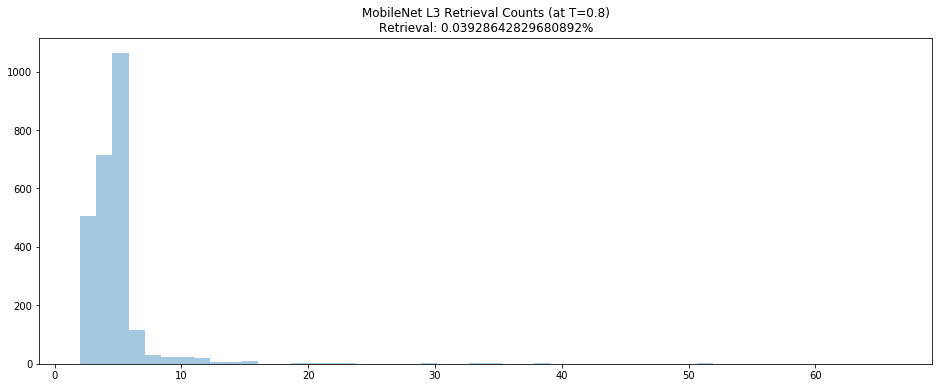

In [12]:
all_ret_counts_t3 = [len(dict_l3_t3[query])for query in dict_l3_t3]
hist_plot(all_ret_counts_t3, f'MobileNet L3 Retrieval Counts (at T=0.8)\nRetrieval: {np.sum(all_ret_counts_t3)*100/len(all_sims)}%')

In [13]:
np.sum(all_ret_counts_t3)

12773

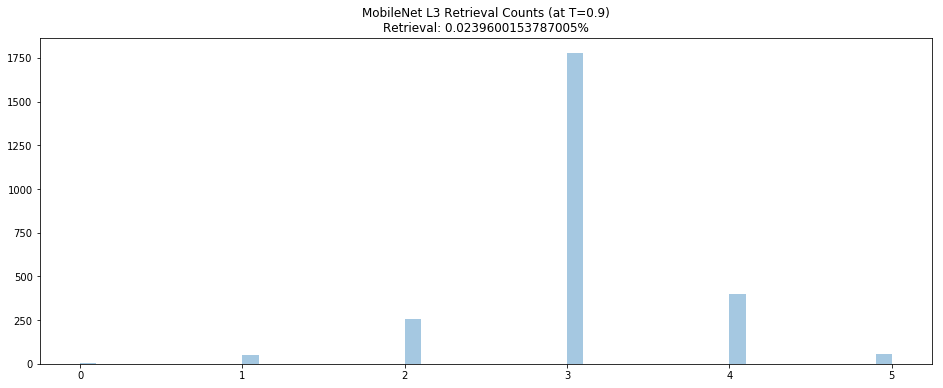

In [14]:
all_ret_counts_t4 = [len(dict_l3_t4[query])for query in dict_l3_t4]
hist_plot(all_ret_counts_t4, f'MobileNet L3 Retrieval Counts (at T=0.9)\nRetrieval: {np.sum(all_ret_counts_t4)*100/len(all_sims)}%')

### 3. Histogram of most frequently returned transformation(at threshold = T)

In [22]:
def transformation_extractor(x):
    return x.split('.')[0].split('_')[1]

def transformation_counter(results_dict):
    suffix_name_correct = []
    suffix_name_incorrect = []
    correct_counter = 0
    incorrect_counter = 0

    for k, v in results_dict.items():
        base_name = k.split('.')[0].split('/')[-1]
        #b_name.append(base_name)
        for val in v:
            base_name_ret = val.split('.')[0].split('_')[0].split('/')[-1]
            transformation_name = transformation_extractor(val)
            #import ipdb; ipdb.set_trace()
            if base_name_ret in base_name:
                suffix_name_correct.append(transformation_name)
                correct_counter += 1
            else:
                suffix_name_incorrect.append(transformation_name)
                incorrect_counter += 1
    return {'correct': Counter(suffix_name_correct), 'incorrect': Counter(suffix_name_incorrect)}

In [24]:
trans_count_d1 = transformation_counter(dict_l3_t1)
trans_count_d2 = transformation_counter(dict_l3_t2)
trans_count_d3 = transformation_counter(dict_l3_t3)
trans_count_d4 = transformation_counter(dict_l3_t4)

#### Visualizing accuracy across different transformation types

In [49]:
trans_perc_d1 = ({
        k: trans_count_d1['correct'][k] * 100 / (trans_count_d1['correct'][k]+trans_count_d1['incorrect'][k])
        for k in trans_count_d1['correct']
    })


trans_perc_d2 = ({
        k: trans_count_d2['correct'][k] * 100 / (trans_count_d2['correct'][k]+trans_count_d2['incorrect'][k])
        for k in trans_count_d2['correct']
    })


trans_perc_d3 = ({
        k: trans_count_d3['correct'][k] * 100 / (trans_count_d3['correct'][k]+trans_count_d3['incorrect'][k])
        for k in trans_count_d3['correct']
    })


trans_perc_d4 = ({
        k: trans_count_d4['correct'][k] * 100 / (trans_count_d4['correct'][k]+trans_count_d4['incorrect'][k])
        for k in trans_count_d4['correct']
    })

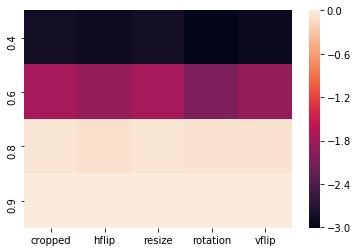

In [59]:
heatmap_acc = {} 
for k in trans_perc_d1:
    heatmap_acc[k] = np.log([trans_perc_d1[k], trans_perc_d2[k], trans_perc_d3[k], trans_perc_d4[k]])/np.log(10)

t = pd.DataFrame.from_dict(heatmap_acc)
t.index = ([0.4, 0.6, 0.8, 0.9])
sns.heatmap(t)
plt.show()

#### Visualizing recall across different transformation types

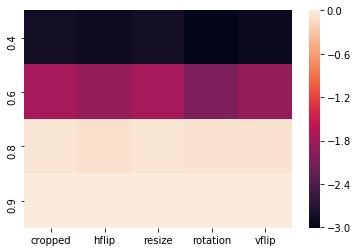

In [60]:
trans_rec_d1 = ({
        k: trans_count_d1['correct'][k] * 100 / 2550
        for k in trans_count_d1['correct']
    })


trans_rec_d2 = ({
        k: trans_count_d2['correct'][k] * 100 / 2550
        for k in trans_count_d2['correct']
    })


trans_rec_d3 = ({
        k: trans_count_d3['correct'][k] * 100 / 2550
        for k in trans_count_d3['correct']
    })


trans_rec_d4 = ({
        k: trans_count_d4['correct'][k] * 100 / 2550
        for k in trans_count_d4['correct']
    })


  ## Plotting 
heatmap_rec = {} 
for k in trans_rec_d1:
    heatmap_rec[k] = np.log([trans_rec_d1[k], trans_rec_d2[k], trans_rec_d3[k], trans_rec_d4[k]])/np.log(10)

t = pd.DataFrame.from_dict(heatmap_acc)
t.index = ([0.4, 0.6, 0.8, 0.9])
sns.heatmap(t)
plt.show()

In [175]:
print(trans_rec_d1)
print(trans_rec_d2)
print(trans_rec_d3)
print(trans_rec_d4)

{'cropped': 100.0, 'hflip': 100.0, 'resize': 100.0, 'rotation': 100.0, 'vflip': 99.76470588235294}
{'cropped': 100.0, 'hflip': 100.0, 'resize': 100.0, 'rotation': 98.58823529411765, 'vflip': 95.33333333333333}
{'cropped': 99.80392156862744, 'hflip': 100.0, 'resize': 100.0, 'vflip': 61.76470588235294, 'rotation': 67.45098039215686}
{'hflip': 99.45098039215686, 'resize': 96.3921568627451, 'vflip': 13.882352941176471, 'cropped': 89.13725490196079, 'rotation': 6.313725490196078}


In [73]:
pd.concat([
    pd.DataFrame(trans_count_d1),
    pd.DataFrame(trans_count_d2),
    pd.DataFrame(trans_count_d3),
    pd.DataFrame(trans_count_d4) 
], axis=1)

,correct,incorrect,correct,incorrect,correct,incorrect,correct,incorrect
cropped,2550,1830861,2550,148032,2545,360,2273,2.0
hflip,2550,2029819,2550,192551,2550,544,2536,5.0
resize,2550,1764861,2550,145337,2550,312,2458,1.0
rotation,2550,2576804,2514,275057,1720,310,161,NaN
vflip,2544,2076831,2431,184498,1575,307,354,NaN


## Benchmarking our experiments
###  `EvalPerformance` records for each of the four thresholds explored

In [106]:
def retrieval_stripper(x):
    return x.lstrip(u'Retrieval')[1:]

dict_ret_1 = {
    k.lstrip(u'Query')[1:]: list(map(retrieval_stripper, dict_l3_t1[k].keys()))
    for k in dict_l3_t1
}

dict_ret_2 = {
    k.lstrip(u'Query')[1:]: list(map(retrieval_stripper, dict_l3_t2[k].keys()))
    for k in dict_l3_t2
}

dict_ret_3 = {
    k.lstrip(u'Query')[1:]: list(map(retrieval_stripper, dict_l3_t3[k].keys()))
    for k in dict_l3_t3
}

dict_ret_4 = {
    k.lstrip(u'Query')[1:]: list(map(retrieval_stripper, dict_l3_t4[k].keys()))
    for k in dict_l3_t4
}

#### Load gold retrievals

In [110]:
GOLD_PATH = '/Users/zubin.john/forge/image-dedup/Transformed_dataset/ground_truth_transformed.pkl'

with open(GOLD_PATH, 'rb') as buf:
        correct_dict = pickle.load(buf)

#### Report metrics for model variant

In [113]:
import sys
sys.path.append('/Users/zubin.john/forge/image-dedup/')
from imagededup.evaluation import EvalPerformance

eval1 = EvalPerformance(correct_dict, dict_ret_1)
for metric, reading in eval1.get_all_metrics().items():
    print(f'[t=0.4] {metric}\t{reading}')

[t=0.4] MAP	0.023746109417896878
[t=0.4] NDCG	0.19253736893601395
[t=0.4] Jaccard	0.010491971856677718


In [115]:
eval2 = EvalPerformance(correct_dict, dict_ret_2)
for metric, reading in eval2.get_all_metrics().items():
    print(f'[t=0.6] {metric}\t{reading}')

[t=0.6] MAP	0.26827606825884404
[t=0.6] NDCG	0.4403159339384259
[t=0.6] Jaccard	0.2155004144278737


In [114]:
eval3 = EvalPerformance(correct_dict, dict_ret_3)
for metric, reading in eval3.get_all_metrics().items():
    print(f'[t=0.8] {metric}\t{reading}')

[t=0.8] MAP	0.8214041018286498
[t=0.8] NDCG	0.9687260713327025
[t=0.8] Jaccard	0.814502907146487


In [116]:
eval4 = EvalPerformance(correct_dict, dict_ret_4)
for metric, reading in eval4.get_all_metrics().items():
    print(f'[t=0.9] {metric}\t{reading}')

[t=0.9] MAP	0.6100444444444444
[t=0.9] NDCG	0.9973100812680736
[t=0.9] Jaccard	0.6100354808590102


## Back to experimentation
### 4. Average similarity score for correct retrievals (at threshold = T)

In [125]:
def correct_counter(results_dict):
    correct_sims = []
    incorrect_sims = []

    for k, v in results_dict.items():
        base_name = k.split('.')[0].split('/')[-1]
        for k_val, v_val in v.items():
            base_name_ret = k_val.split('.')[0].split('_')[0].split('/')[-1]
            if base_name_ret in base_name:
                correct_sims.append(v_val)
            else:
                incorrect_sims.append(v_val)
    return {'correct': correct_sims, 'incorrect': incorrect_sims}

In [134]:
sim_score_dict_l3_t1 = correct_counter(dict_l3_t1)

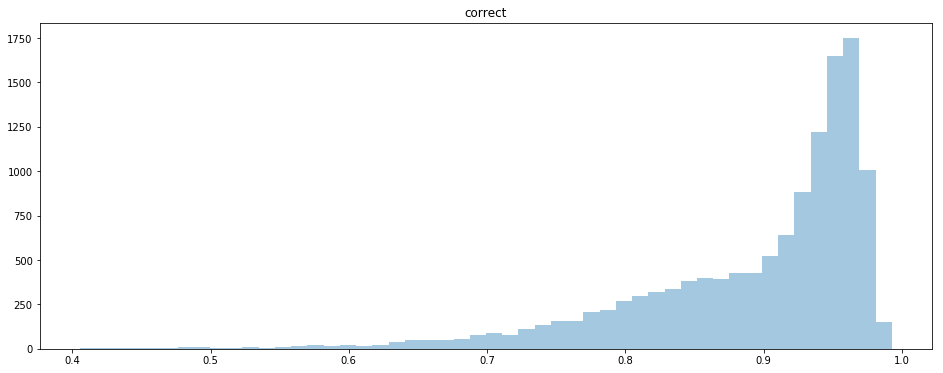

In [135]:
hist_plot(sim_score_dict_l3_t1['correct'], 'correct')

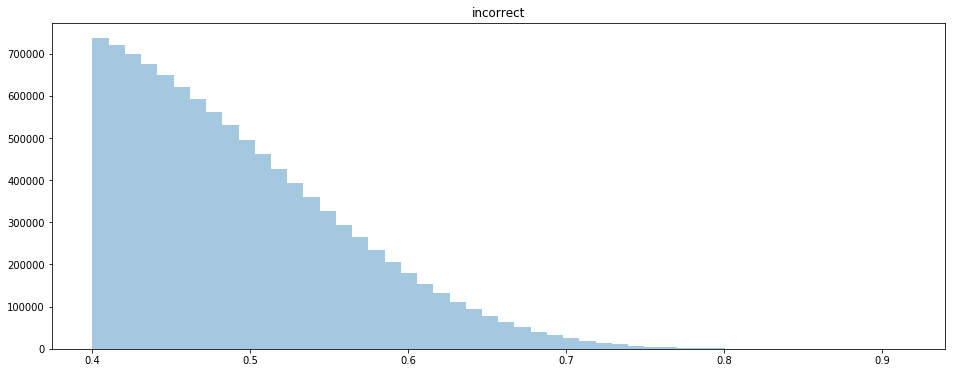

In [136]:
hist_plot(sim_score_dict_l3_t1['incorrect'], 'incorrect')

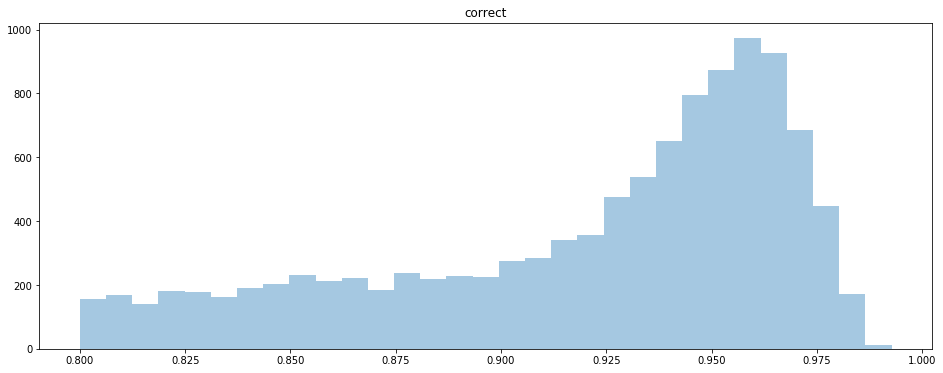

In [139]:
sim_score_dict_l3_t3 = correct_counter(dict_l3_t3)
hist_plot(sim_score_dict_l3_t3['correct'], 'correct')

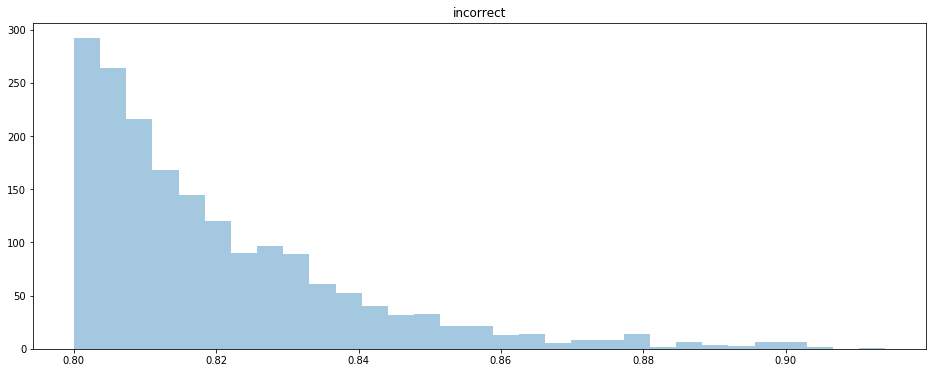

In [140]:
hist_plot(sim_score_dict_l3_t3['incorrect'], 'incorrect')

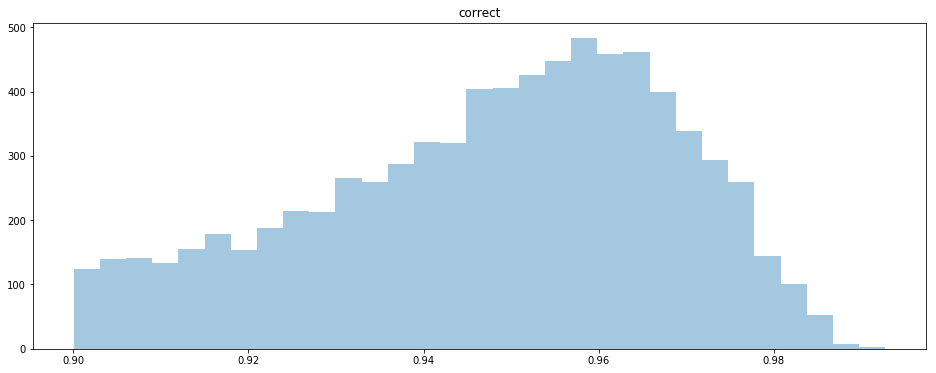

In [137]:
sim_score_dict_l3_t4 = correct_counter(dict_l3_t4)
hist_plot(sim_score_dict_l3_t4['correct'], 'correct')

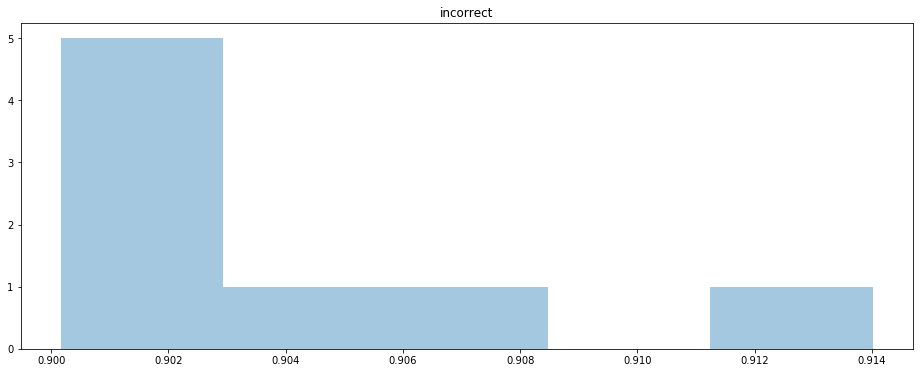

In [138]:
hist_plot(sim_score_dict_l3_t4['incorrect'], 'incorrect')

In [146]:
print(np.mean(sim_score_dict_l3_t1['correct']))
print(np.mean(sim_score_dict_l3_t1['incorrect']))

0.89227337
0.4943006


In [144]:
print(np.mean(sim_score_dict_l3_t3['correct']))
print(np.mean(sim_score_dict_l3_t3['incorrect']))

0.9205205
0.8201341


In [145]:
print(np.mean(sim_score_dict_l3_t4['correct']))
print(np.mean(sim_score_dict_l3_t4['incorrect']))

0.94765955
0.904081


### 6. Average similarity score for each type of transformation

In [151]:
def transformation_extractor(x):
    return x.split('.')[0].split('_')[1]

def transformation_sim_score(results_dict):
    suffix_name_correct = []
    suffix_name_incorrect = []
    correct_counter = 0
    incorrect_counter = 0
   
    correct_dict = defaultdict(list)
    incorrect_dict = defaultdict(list)

    for k, v in results_dict.items():
        base_name = k.split('.')[0].split('/')[-1]
        for k_val, v_val in v.items():
            base_name_ret = k_val.split('.')[0].split('_')[0].split('/')[-1]
            transformation_name = transformation_extractor(k_val)
            if base_name_ret in base_name:
                suffix_name_correct.append(transformation_name)
                # correct_counter += 1
                correct_dict[transformation_name].append(v_val)
            else:
                suffix_name_incorrect.append(transformation_name)
                # incorrect_counter += 1
                incorrect_dict[transformation_name].append(v_val)
    return correct_dict, incorrect_dict

In [152]:
correct_dict_l3_t1, incorrect_dict_l3_t1 = transformation_sim_score(dict_l3_t1)
correct_dict_l3_t3, incorrect_dict_l3_t3 = transformation_sim_score(dict_l3_t3)

In [174]:
for op in correct_dict_l3_t3:
    print(f'{op}: {np.mean(correct_dict_l3_t3[op])}, {np.mean(incorrect_dict_l3_t3[op])}')

cropped: 0.9332269430160522, 0.8217760920524597
hflip: 0.9587452411651611, 0.8232632875442505
resize: 0.9468368887901306, 0.8189552426338196
vflip: 0.8671306371688843, 0.8176788687705994
rotation: 0.8549227118492126, 0.8163541555404663


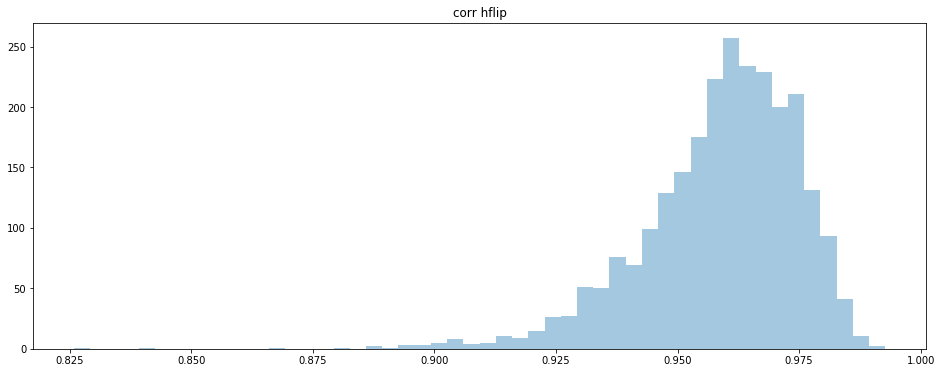

In [158]:
hist_plot(correct_dict_l3_t1['hflip'], "corr hflip")

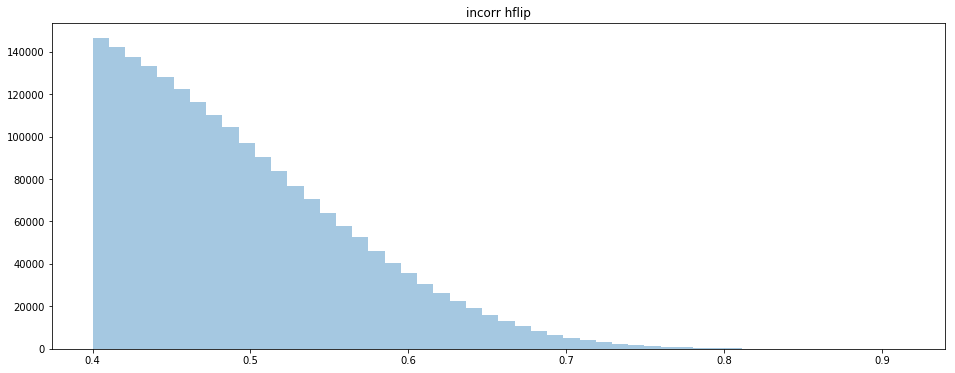

In [159]:
hist_plot(incorrect_dict_l3_t1['hflip'], "incorr hflip")

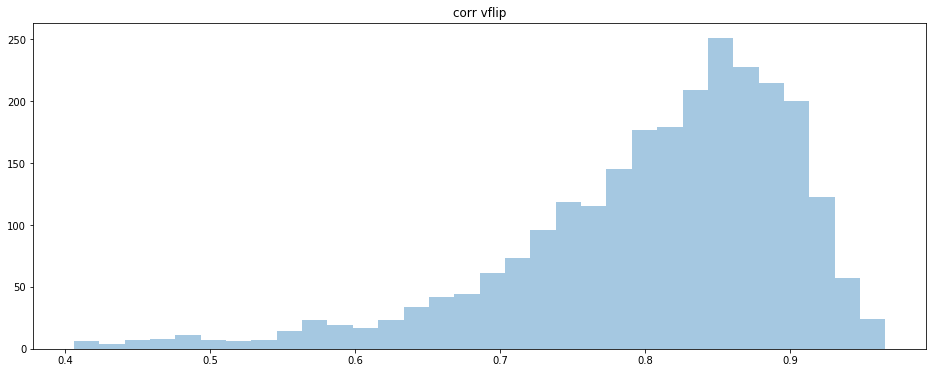

In [160]:
hist_plot(correct_dict_l3_t1['vflip'], "corr vflip")

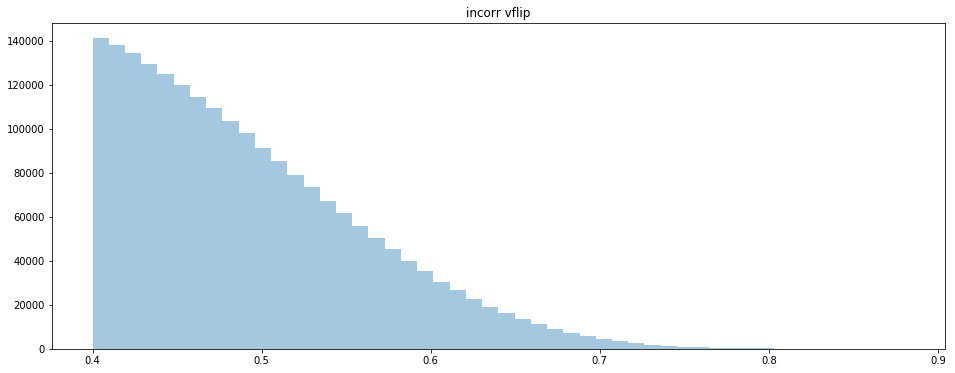

In [161]:
hist_plot(incorrect_dict_l3_t1['vflip'], "incorr vflip")

## Observations
+ Most of the mass for similarity score is located in the positive range
+ Distribution is uni-modal

### Transformation Analysis
+ Accuracy is highest with threshold of `0.9`
+ Recall is lowest at threshold of `0.9`
+ _vflips_ and _rotations_ are culprits for poor recall - the correctness confidence is lower when compared to other transformations